# CINNAMON CLUSTERING REPORT

## Báo cáo assignment ___Clustering___

Nội dung báo cáo gồm
- Phân tích dữ liệu
- Features Extraction
- Tính độ tương đồng, recommend (cosine)
- KNN, Clustering
- Nhận xét

### Phân tích dữ liệu

Load thư viện

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Đọc dữ liệu, loại bỏ cột URI

In [2]:
data_all = pd.read_csv('people_wiki.csv').drop('URI', axis=1)

# Shuffle cho khách quan
data_all = data_all.sample(frac=1).reset_index(drop=True)
data_all.head()

,name,text
0,Sarah Pedinotti,sarah pedinotti is an american songwriter and ...
1,Maxim Korobov,maxim leonidovich korobov born december 3 1957...
2,Leon Menezes,leon menezes is a pakistani management profess...
3,Cynthia Weber,cynthia weber is a professor of international ...
4,Markus Aspelmeyer,markus aspelmeyer is an austrian quantum physi...


Sử dụng thư viện ___nltk___ để stemming và loại bỏ ___stopwords___

Ngôn ngữ của data chỉ có tiếng anh

In [3]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

- ```important(text)```: lọc ra các danh từ và tính từ quan trọng
- ```cleaner(text)```: hàm loại bỏ các kí tự lạ

In [5]:
def important(text):
    # Văn bản sau khi clean đơn giản nên chỉ cần tách dấu cách
    tokens = text.split(' ')
    tags = nltk.pos_tag(tokens)
    nouns = [word for word, pos in tags if (pos == 'JJ' or pos.startswith('NN'))]
    return nouns

def cleaner(text):
    # Loại bỏ chữ ngắn hơn 2 kí tự, các kí tự không phải là chữ
    short = re.sub(r'\b[a-zA-Z-]{0,2}\b|[^a-zA-Z- ]+', '', text.replace('\\', '').lower())
    # Loại bỏ các dấu cách liên nhau
    space = re.sub(r'[ ]{2,}', ' ', short)
    trimm = re.sub(r' $|^\s+', '', space)
    return trimm

In [6]:
# Lọc ra Obama
obama_text = data_all[data_all['name'] == 'Barack Obama']['text'].values[0]
obama_text

'barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the united states and the first african american to hold the office born in honolulu hawaii obama is a graduate of columbia university and harvard law school where he served as president of the harvard law review he was a community organizer in chicago before earning his law degree he worked as a civil rights attorney and taught constitutional law at the university of chicago law school from 1992 to 2004 he served three terms representing the 13th district in the illinois senate from 1997 to 2004 running unsuccessfully for the united states house of representatives in 2000in 2004 obama received national attention during his campaign to represent illinois in the united states senate with his victory in the march democratic party primary his keynote address at the democratic national convention in july and his election to the senate in november he began his presidential campaign in 2007 and afte

Xem các token mà ta thu thập được

In [7]:
print(important(cleaner(obama_text)))

['barack', 'hussein', 'brk', 'husen', 'current', 'president', 'united', 'states', 'first', 'african', 'american', 'office', 'honolulu', 'hawaii', 'obama', 'graduate', 'columbia', 'university', 'harvard', 'law', 'school', 'president', 'harvard', 'law', 'review', 'community', 'law', 'degree', 'civil', 'rights', 'attorney', 'taught', 'constitutional', 'law', 'university', 'chicago', 'law', 'school', 'terms', 'district', 'illinois', 'senate', 'united', 'states', 'house', 'representatives', 'obama', 'national', 'attention', 'campaign', 'represent', 'united', 'states', 'victory', 'march', 'democratic', 'party', 'primary', 'keynote', 'democratic', 'national', 'convention', 'july', 'election', 'senate', 'november', 'presidential', 'campaign', 'close', 'primary', 'campaign', 'hillary', 'rodham', 'clinton', 'sufficient', 'democratic', 'party', 'primaries', 'presidential', 'nomination', 'republican', 'nominee', 'john', 'general', 'election', 'president', 'january', 'months', 'election', 'obama', 

In [8]:
def split_only(text):
    return text.split(' ')

Để truy vấn không phân biệt viết hoa, dấu cách,.. ta encode tên mỗi người

In [9]:
def encoder(text):
    nom = re.sub(r'[^a-zA-Z-]+', '-', text.lower())
    space = re.sub(r'[-]{2,}', '-', nom)
    trimm = re.sub(r'-$|^\s+', '', space)
    return trimm

In [10]:
encoder('Charles Foster (athlete)')

'charles-foster-athlete'

Chuẩn hóa dữ liệu

In [11]:
data_all['name_encoded'] = data_all['name'].apply(lambda s: encoder(s))
data_all['text_encoded'] = data_all['text'].apply(lambda s: ' '.join(important(cleaner(s))))
data_all.drop(['name', 'text'], axis=1).to_csv('feat.csv', index=False)
data_all.head()

,name,text,name_encoded,text_encoded
0,Sarah Pedinotti,sarah pedinotti is an american songwriter and ...,sarah-pedinotti,sarah pedinotti american songwriter musician s...
1,Maxim Korobov,maxim leonidovich korobov born december 3 1957...,maxim-korobov,maxim leonidovich korobov russian businessman ...
2,Leon Menezes,leon menezes is a pakistani management profess...,leon-menezes,leon pakistani management professorhe karachi ...
3,Cynthia Weber,cynthia weber is a professor of international ...,cynthia-weber,cynthia weber professor international relation...
4,Markus Aspelmeyer,markus aspelmeyer is an austrian quantum physi...,markus-aspelmeyer,markus aspelmeyer austrian quantum physicistas...


### Features extraction

Sử dụng ___TF IDF___ trên tập dữ liệu đã làm sạch với tham số như sau:
- ```max_df=0.5```: bỏ các từ có tần xuất xuất hiện vượt quá 50% lượng văn bản (nhiều quá thành nhảm)
- ```max_features=900```: lấy ra top 900 từ xuất hiện nhiều
- ```min_df=5```: bỏ các từ có tần xuất xuất hiện ít hơn 5 văn bản
- ```ngram_range=(1,1)```: do chỉ lấy từ khóa, ko theo thứ tự nên chỉ lấy ngram = 1 

![Tf-IDF](images/tfidf.png)

In [12]:
vectorizer = TfidfVectorizer(max_df=0.5,
                             max_features=900,
                             min_df=5,
                             use_idf=True,
                             ngram_range=(1,1),
                             tokenizer=split_only)
features = vectorizer.fit_transform(data_all['text_encoded']) 

In [13]:
print("n_samples: %d, n_features: %d" % features.shape)

n_samples: 59071, n_features: 900


Điểm qua một vào feature words

In [14]:
vocab = vectorizer.get_feature_names()
# vocab

Xem ma trận tf idf của Obama

In [15]:
# obama_index = data_all.index[data_all['name_encoded'] == encoder('Barack Obama')].tolist()[0]
# arr = features[obama_index].toarray()[0]
# dem = 0
# for x, w in zip(arr, vocab):
#     if x != 0:
#         print(w, x)
#         dem += 1
# print("Total", dem)

Giảm chiều nếu cần

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from scipy import sparse

svd = TruncatedSVD(35)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

features = lsa.fit_transform(features)
features = sparse.csr_matrix(features)

### Tính độ tương đồng, recommend (cosine)

Sử dụng hàm khoảng cách cosine của thư viện sklearn

In [17]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import MDS
from scipy.sparse import vstack

In [18]:
matrix = features

Hàm ```distance``` tính khoảng cách giữa 2 người

Càng lớn tức là càng không liên quan đến nhau

In [19]:
def distance(name1, name2):
    index1 = data_all.index[data_all['name_encoded'] == encoder(name1)].tolist()[0]
    index2 = data_all.index[data_all['name_encoded'] == encoder(name2)].tolist()[0]
    
    return cosine_distances(matrix[index1], matrix[index2]).flatten()[0]

Visualize khoảng cách

In [20]:
def plot_similar(matrix, keys):
    stack = []
    for k in keys:
        index = data_all.index[data_all['name_encoded'] == encoder(k)].tolist()[0]
        stack.append(matrix[index:index+1])
    
    dist = cosine_distances(vstack((stack)))
    
    # Sử dụng multidimensional scaling để visualize
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=111)
    pos = mds.fit_transform(dist)
    
    xs, ys, names = pos[:, 0], pos[:, 1], keys
    for x, y, name in zip(xs, ys, names):
        plt.scatter(x, y)
        plt.text(x, y, name)    
    
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.show()
    print(dist)

Thử với Barack Obama, George W. Bush, Joe Biden và Justin Bieber

Ba người đầu tiên làm chính trị nên phải gần nhau

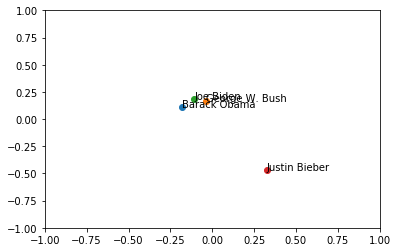

[[0.         0.13707817 0.11054353 0.77981982]
 [0.13707817 0.         0.07195517 0.72368668]
 [0.11054353 0.07195517 0.         0.78769185]
 [0.77981982 0.72368668 0.78769185 0.        ]]


In [21]:
plot_similar(features, ['Barack Obama', 'George W. Bush', 'Joe Biden', 'Justin Bieber'])

Qua đây thấy kết quả đúng như ta dự đoán 

cosine_distances trả về giá trị nằm trong khoảng [0.0, 1.0]

In [22]:
print(distance('Barack Obama', 'George W. Bush'))
print(distance('Barack Obama', 'Joe Biden'))
print(distance('Joe Biden', 'George W. Bush'))
print(distance('Barack Obama', 'Justin Bieber'))

0.13707816712458853
0.11054352814898771
0.07195517017341702
0.7798198209713064


Hàm ```recommend``` nhận vào tên người đang đọc, và k người cần recommend, trả về 1 dataframe

In [23]:
def recommend(name, k = 5):
    indexx = data_all.index[data_all['name_encoded'] == encoder(name)].tolist()[0]
    
    # Độ tương đồng là ngược của khoảng cách
    cosine_similarities = 1 - cosine_distances(matrix[indexx], matrix).flatten()
    
    # Sort
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != indexx]
    
    # Lấy index của top K người cao nhất
    results = [(indexx, 1.0)] + [(index, cosine_similarities[index]) for index in related_docs_indices][:k]
    
    # Nhét vào dataframe
    results_df = pd.DataFrame(columns=['index', 'name', 'text', 'score'])
    j = 0
    for i, p in results:
        data = data_all.loc[i]
        results_df.loc[j] = [i, data['name'], data['text_encoded'], p]
        j += 1
    return results_df

Thử với Obama, kết quả rất tốt

In [24]:
friends = recommend('Barack Obama')
friends.values

array([[58827, 'Barack Obama',
        'barack hussein brk husen current president united states first african american office honolulu hawaii obama graduate columbia university harvard law school president harvard law review community law degree civil rights attorney taught constitutional law university chicago law school terms district illinois senate united states house representatives obama national attention campaign represent united states victory march democratic party primary keynote democratic national convention july election senate november presidential campaign close primary campaign hillary rodham clinton sufficient democratic party primaries presidential nomination republican nominee john general election president january months election obama nobel peace prize first years office obama law economic stimulus legislation response great recession form american recovery reinvestment act tax relief unemployment insurance reauthorization job creation act other major domestic i

WordCloud

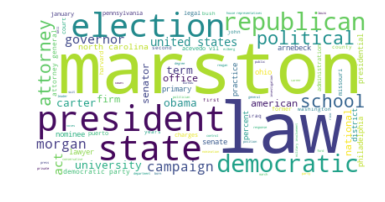

In [25]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
plt.imshow(wordcloud.generate(' '.join(friends['text'])), interpolation='bilinear')
plt.axis("off")
plt.show()

### KNN, Clustering

Dùng KNN để search neighbors

In [26]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5, radius=0.4, metric='cosine', n_jobs=-1)
neigh.fit(features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=0.4)

Hàm new_recommend dùng KNN

In [27]:
def new_recommend(name, k = 5):
    indexx = data_all.index[data_all['name_encoded'] == encoder(name)].tolist()[0]
    
    # Độ tương đồng là ngược của khoảng cách
    x = matrix[indexx]
    results = neigh.kneighbors(x, k, True)
    
    # Nhét vào dataframe
    results_df = pd.DataFrame(columns=['index', 'name', 'text', 'score'])
    j = 0
    for i, p in zip(results[1][0], results[0][0]):
        data = data_all.loc[i]
        results_df.loc[j] = [i, data['name'], data['text_encoded'], 1 - p]
        j += 1
    return results_df

In [28]:
new_recommend('Barack Obama', 5).values

array([[58827, 'Barack Obama',
        'barack hussein brk husen current president united states first african american office honolulu hawaii obama graduate columbia university harvard law school president harvard law review community law degree civil rights attorney taught constitutional law university chicago law school terms district illinois senate united states house representatives obama national attention campaign represent united states victory march democratic party primary keynote democratic national convention july election senate november presidential campaign close primary campaign hillary rodham clinton sufficient democratic party primaries presidential nomination republican nominee john general election president january months election obama nobel peace prize first years office obama law economic stimulus legislation response great recession form american recovery reinvestment act tax relief unemployment insurance reauthorization job creation act other major domestic i

Thử với phân cụm

- KMeans trong thư viện sklearn không hỗ trợ khoảng cách ___cosine___ nên ta tự implement thuật toán kmeans riêng. 
- Để đánh giá việc phân cụm của Kmeans, người ta thường dùng ___Silhouette Coefficient___ nhưng do không đủ memory, ta đề xuất một thuật toán khác là [tdigest](https://github.com/tdunning/t-digest/blob/master/docs/t-digest-paper/histo.pdf)

Cách thức đánh giá:
- Tính khoảng cách các điểm x đến center của chúng, nhét vào tdigest => xong tính ___percentile 95___ mong đợi chỉ có 5% dữ liệu phân cụm sai. Chỉ số càng bé là càng tốt

In [29]:
from kmeans import *

In [30]:
X = features.toarray()
print(X.shape)
for K in [15, 20, 25, 30, 30, 35, 45, 50]:
    km = KMeansCosine(K, metric='cosine')
    km.fit(X)
    score = np.mean(km.score(q=0.95))
    print(K, score)

(59071, 35)
15 0.4590758688523436
20 0.4473883564668332
25 0.3742016096257623
30 0.3769726574399385
30 0.3595846416494102
35 0.32294587388569584
45 0.2922018931760577
50 0.3020351247530924


Ta chọn K = 45

In [31]:
km = KMeansCosine(45, metric='cosine')
km.fit(X)

In [32]:
data_all['label'] = km.labels
data_all['distance'] = km.distance()
# data_all.drop(['name_encoded', 'text_encoded'], axis=1).to_csv('result.csv', index=False)
data_all.head()

,name,text,name_encoded,text_encoded,label,distance
0,Sarah Pedinotti,sarah pedinotti is an american songwriter and ...,sarah-pedinotti,sarah pedinotti american songwriter musician s...,15,0.116295
1,Maxim Korobov,maxim leonidovich korobov born december 3 1957...,maxim-korobov,maxim leonidovich korobov russian businessman ...,2,0.159068
2,Leon Menezes,leon menezes is a pakistani management profess...,leon-menezes,leon pakistani management professorhe karachi ...,14,0.107477
3,Cynthia Weber,cynthia weber is a professor of international ...,cynthia-weber,cynthia weber professor international relation...,18,0.188979
4,Markus Aspelmeyer,markus aspelmeyer is an austrian quantum physi...,markus-aspelmeyer,markus aspelmeyer austrian quantum physicistas...,6,0.250963


In [33]:
def new_recommend2(name, k = 5):
    label = data_all[data_all['name_encoded'] == encoder(name)]['label'].tolist()[0]
    data = data_all[data_all['label'] == label].sort_values('distance')[:k]
    return data.values

In [34]:
new_recommend2('Barack Obama')

array([['Vincent Marchiselli',
        'vincent andrew marchiselli august 18 1928 november 29 2013 was a democratic member of the new york state assembly from the bronx new york he was born in the bronx new yorkbefore getting involved in politics marchiselli was president of his own funeral home marchiselli funeral homes in the bronx marchiselli first ran for office in 1970 but lost the democratic primary for assembly in the 86th district to incumbent anthony j stella in 1974 marchiselli was elected to the assembly defeating republican victor b tosi in a competitive race marchiselli was reelected to four terms marchiselli was affiliated with the reform wing of bronx democrats who included thenassemblymen oliver koppell and eliot l engel the reform democrats in the bronx often clashed with the regular democrats who strongly supported the powerful bronx democratic county political machine and its chairmen such as charles a buckley patrick cunningham and stanley m friedman although libera